In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from typing import Optional, Sequence
from functools import partial

import numpy as np
from coba.experiments.tasks import SimpleEvaluation
from coba import CobaRandom, Environments, RandomLearner, Experiment, VowpalSoftmaxLearner, VowpalBagLearner
from coba.environments import LambdaSimulation
from coba.primitives import Context, Action
from matplotlib import pyplot as plt
from pandas import DataFrame
import pandas as pd

# Run Simulation

In [10]:
class CustomEnvironment(LambdaSimulation):
    def __init__(self, n_interactions: Optional[int] = 1000):
        super().__init__(n_interactions, self.context, self.actions, self.rewards)
        self.r = CobaRandom(1)

    def actions(self, index: int, context: Context) -> Sequence[Action]:
        """
        actions: A function that should return all valid actions for a given index, context and random state.
        """
        return [0, 1]

    def context(self, index: int) -> Context:
        return {
            "feature_1": self.r.randoms(1)[0],
            "feature_2": self.r.randoms(1)[0],
            "feature_3": self.r.randoms(1)[0]
        }

    def rewards(self, index: int, context: Context, action: Action) -> float:
        # reward centered around 0.5, with feature_1 strongly positively correlating with the reward for the first action 
        # and feature_2 half as much negatively correlating
        reward_probabilities_for_actions = [
            0.5 
                + 1.0 * (context["feature_1"] - 0.5) 
                - 0.5 * (context["feature_2"] - 0.5),
            0.5
        ]
        
        reward_probabilities_for_actions = [min(1.0, max(0.0, prob)) for prob in reward_probabilities_for_actions]
        return np.random.binomial(1, reward_probabilities_for_actions[action])

environments = Environments([CustomEnvironment(5000)]).shuffle(n=4)
learners = [
    VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax']),
    RandomLearner(),
]
result = Experiment(
    environments,
    learners,
    evaluation_task=SimpleEvaluation(record=['reward','probability','action','context'])
).run()

2023-01-26 13:52:22 -- Processing chunk...
2023-01-26 13:52:22 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-01-26 13:52:22 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-01-26 13:52:22 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2023-01-26 13:52:22 --   * Peeking at Environment 0... (0.03 seconds) (completed)
2023-01-26 13:52:22 --   * Evaluating Learner 0 on Environment 0... (0.24 seconds) (completed)
2023-01-26 13:52:22 --   * Peeking at Environment 0... (0.03 seconds) (completed)
2023-01-26 13:52:22 --   * Evaluating Learner 1 on Environment 0... (0.03 seconds) (completed)
2023-01-26 13:52:22 --   * Recording Environment 1 statistics... (0.0 seconds) (completed)
2023-01-26 13:52:22 --   * Peeking at Environment 1... (0.03 seconds) (completed)
2023-01-26 13:52:22 --   * Evaluating Learner 0 on Environment 1... (0.23 seconds) (completed)
2023-01-26 13:52:22 --   * Peeking at Environment 1... (0.03 seconds) 

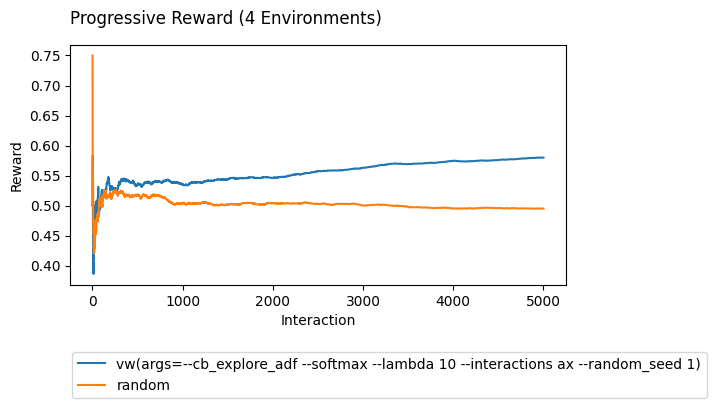

In [11]:
result.plot_learners()

array([[<AxesSubplot: title={'center': 'reward'}>]], dtype=object)

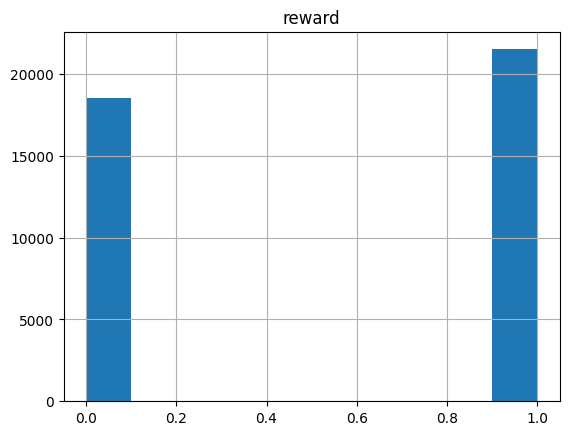

In [12]:
df = result.interactions.to_pandas()
df.hist(column='reward')

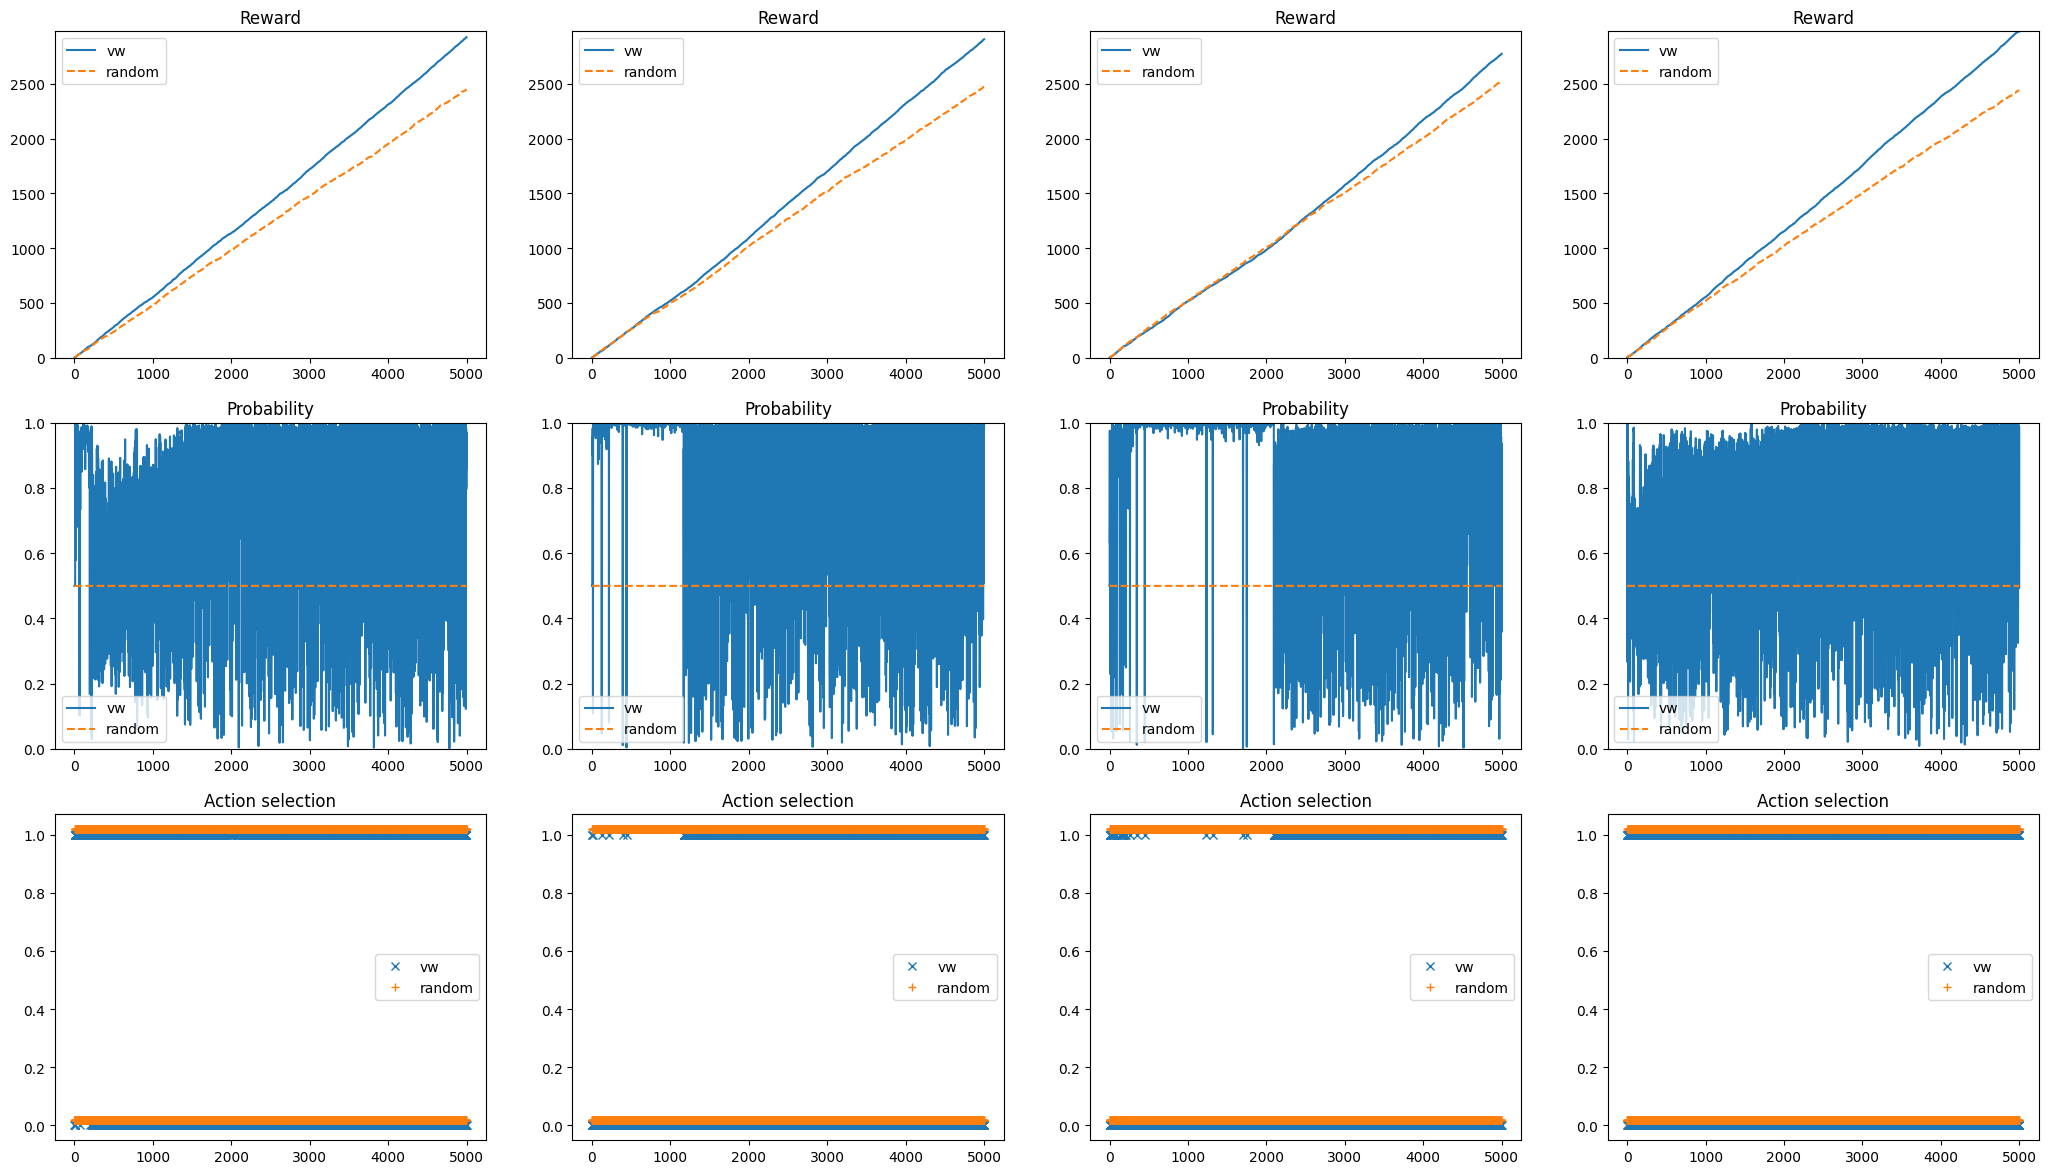

In [13]:
result.plot_overview()

# Prepare Simulation Data for Analysis

In [14]:
vw_model_results = df[df['learner_id'] == 0]

In [15]:
results_for_one_experiment = vw_model_results[vw_model_results['environment_id'] == 0]
results_for_one_experiment.reset_index(inplace=True)

In [16]:
learner = results_for_one_experiment['learner'][0]
action, score, pred_info = learner.predict(context={
    'feature_1': 1,
    'feature_2': 1,
    'feature_3': 1},
    actions=[0,1])
(action, score)

(0, 0.854299008846283)

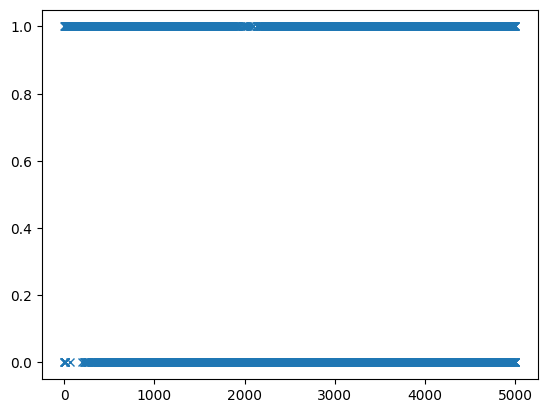

In [17]:
plt.plot(results_for_one_experiment['action'], 'x')

In [18]:
features_only = pd.json_normalize(results_for_one_experiment['context'])
features_only.iloc[:10,:]

,feature_1,feature_2,feature_3
0,0.108635,0.798009,0.440324
1,0.637793,0.448956,0.128464
2,0.840703,0.960418,0.181481
3,0.030389,0.596989,0.787137
4,0.221922,0.728801,0.253342
5,0.631582,0.182279,0.880220
6,0.547675,0.904668,0.217223
7,0.684048,0.910324,0.905249
8,0.812220,0.397470,0.894995
9,0.138136,0.826146,0.216754


# Generate SHAP values

In [19]:
from shap import KernelExplainer, Explanation, force_plot, summary_plot, initjs, dependence_plot
from shap.plots import waterfall, heatmap, beeswarm

In [20]:
# TODO clean this up a bit, look into batch predict of VW model
def batch_predict(feature_values, actions, feature_names):
    result_batch = []
    for features in feature_values:
        context = dict(zip(feature_names, features))
        result = learner.predict(context=context, actions=actions)[0]
        result_batch.append(result)
#         print(f'{result} | {context}')
    return np.array(result_batch)

In [21]:
explainer = KernelExplainer(partial(batch_predict, actions=[0,1], feature_names=features_only.columns), features_only)

Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [22]:
SHAP_VALUES_COUNT = 100
shap_values = explainer.shap_values(features_only.iloc[:SHAP_VALUES_COUNT,:])

  0%|          | 0/100 [00:00<?, ?it/s]

# Feature Importance Analysis

In [23]:
initjs()

In [24]:
explanations = Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=features_only[:len(shap_values)],
    feature_names=features_only.columns
)

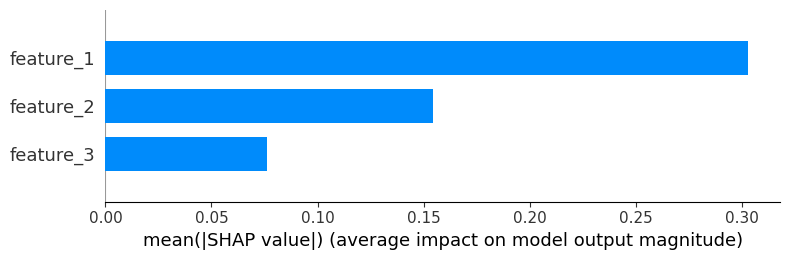

In [25]:
# Overall feature importance
summary_plot(explanations, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


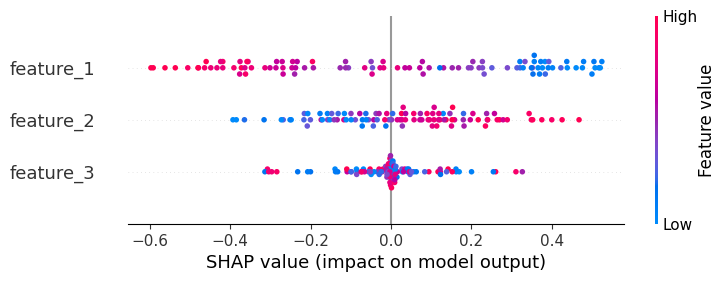

In [26]:
# Showing the distribution of features and their impact on the output
beeswarm(explanations)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


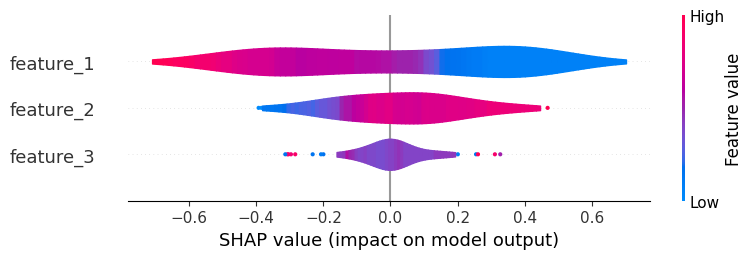

In [27]:
# Alternate visualization to beeswarm
summary_plot(explanations, plot_type="violin")

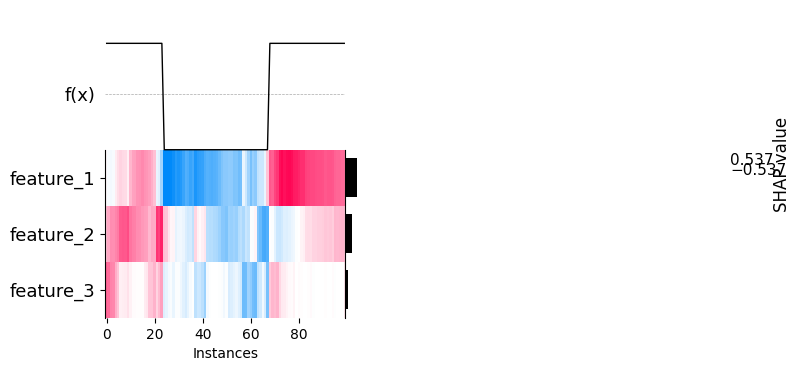

In [28]:
# formatting a bit buggy https://github.com/slundberg/shap/issues/2757
# color coding is for high/low SHAP value
heatmap(explanations)

In [29]:
# colors indicate which output value the features contribute to (not the magnitude of the feature)
# drop-downs allow for slicing and dicing the data
force_plot(explanations)

# Row-level Analysis

In [30]:
ROW_INDEX = 2

explanation = Explanation(
    values=shap_values[ROW_INDEX],
    base_values=explainer.expected_value,
    data=features_only.iloc[ROW_INDEX],
    feature_names=features_only.columns
)

In [31]:
# feature contribution to output
force_plot(explanation)

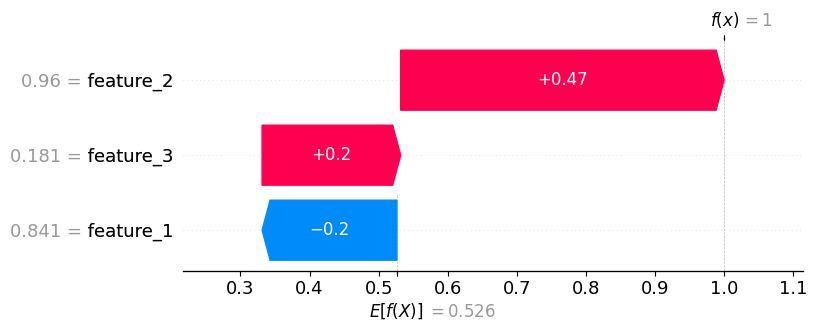

In [32]:
# feature contribution to output broken out with value
waterfall(explanation)

# Feature-level Analysis

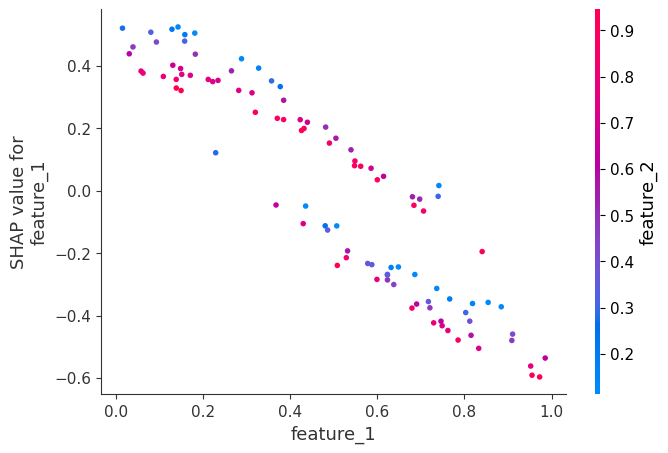

In [33]:
dependence_plot("feature_1", shap_values, features_only[:100])

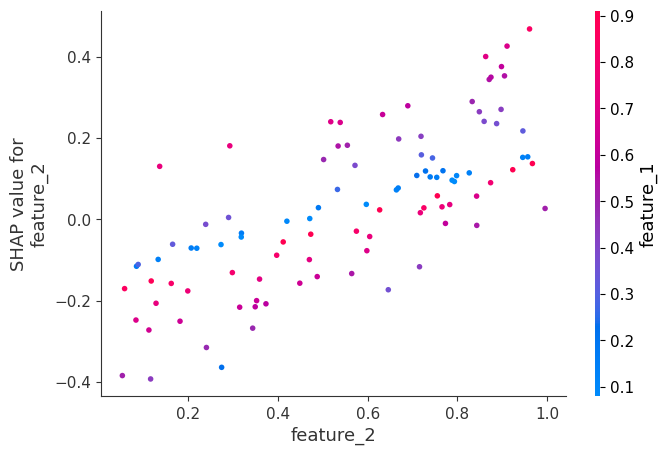

In [34]:
dependence_plot("feature_2", shap_values, features_only[:100])

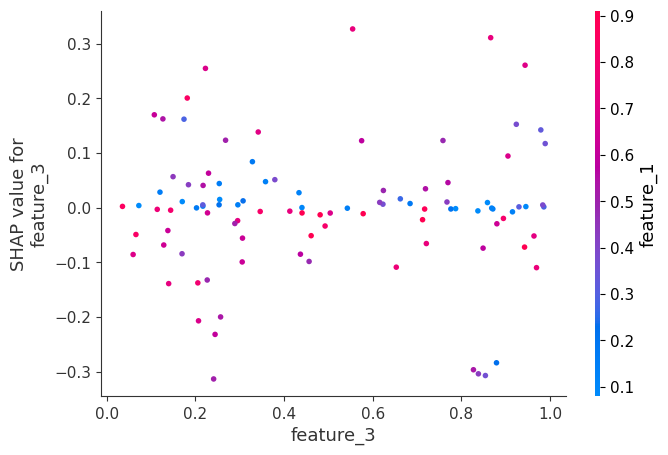

In [35]:
dependence_plot("feature_3", shap_values, features_only[:100])